## 1-D Toy Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

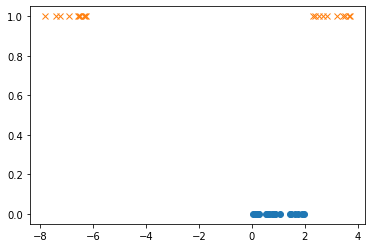

In [29]:
x_0 = np.random.rand(20,1)*2
x_1_1 = np.random.rand(10,1)*2+2
x_1_2 = np.random.rand(10,1)*2-8
x_1 = np.concatenate((x_1_1,x_1_2))

data = np.concatenate((x_0,x_1))
target = np.concatenate((np.zeros((20,1))-1,np.ones((20,1))))

plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.show()

In [30]:
def covariance_function(x1,x2,length,signal_var,noise_var):
    size1 = x1.shape[0]
    size2 = x2.shape[0]
    out = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2): 
            xp = x1[i]
            xq = x2[j]
            out[i,j] =signal_var * math.exp(-1/2*(abs(xp-xq)**2)/length)+noise_var*(i==j)
    return out

## Laplace Approximation

In [4]:
def logit_function(x):
    return 1/(1+np.exp(-x))

In [5]:
f = np.zeros_like(target)
K = covariance_function(data,data,1,1,0.1)
K_inv = np.linalg.inv(K)

In [6]:
error = 100
while error>1e-6:
    pi = logit_function(f)
    W = np.zeros((f.shape[0],f.shape[0]))
    temp = (pi*(1-pi)).reshape(-1).tolist()
    np.fill_diagonal(W,temp)
    dp = (target+1)/2 - pi
    cov = np.linalg.inv(K_inv+W)
    f_new = np.matmul(cov,np.matmul(W,f)+dp)
    error = np.sum(np.abs(f_new-f))
    print(error)
    f = f_new
f_hat = f

50.84825597339089
7.244310388841113
0.38575079326794337
0.001410342520087371
2.1776647637916646e-08


In [7]:
x_star = np.linspace(-9,5,200)
k_star = covariance_function(data,x_star,1,1,0.1)
predicted_mean = np.matmul(np.matmul(k_star.T,K_inv),f_hat)
predicted_var = covariance_function(x_star,x_star,1,1,0.1) - np.matmul(np.matmul(k_star.T,cov),k_star)

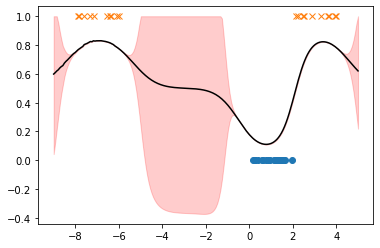

In [10]:
logit_predicted_mean = logit_function(predicted_mean).reshape(-1)
a = predicted_var.diagonal()
a = logit_function(a)
a = np.sqrt(a)
plt.figure()
plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.plot(x_star.reshape(-1),logit_predicted_mean,color='k')
plt.fill_between(x_star.reshape(-1), (logit_predicted_mean-a).clip(-1,1),(logit_predicted_mean+a).clip(-1,1),alpha=0.2,color='r')
plt.show()

## Expectation Propagation

In [31]:
import scipy.stats
NormalDistribution=scipy.stats.norm(0, 1)

In [68]:
error = 100
mu = np.zeros((data.shape[0],1))
sigma = K


mu_last = np.zeros((data.shape[0],1))
sigma_last = K

nu_tilda = np.zeros((data.shape[0],1))
tau_tilda = np.zeros(data.shape[0])

# mu_tilda_new = np.zeros((data.shape[0],1))
# sigma_tilda_new = np.ones(data.shape[0])

# sigma_minus = np.zeros(data.shape[0])
# mu_minus = np.zeros(data.shape[0])

# sigma_hat = np.zeros(data.shape[0])
# mu_hat = np.zeros(data.shape[0])
while error>1e-2:
    for i in range(0,data.shape[0]):
        
        tau_minus = sigma[i,i]**(-2) - tau_tilda[i]
        nu_minus = sigma[i,i]**(-2)*mu[i] - nu_tilda[i]
        sigma_minus = tau_minus**2
        mu_minus = nu_minus / tau_minus
        z_i = (target[i]*mu_minus)/math.sqrt(1+sigma_minus**2)
        mu_hat_i = mu_minus + (NormalDistribution.pdf(z_i)*target[i]*sigma_minus**2) \
                                    /(NormalDistribution.cdf(z_i)*math.sqrt(1+sigma_minus**2))

        sigma_hat_i = sigma_minus**(-2) - sigma_minus**(4)*NormalDistribution.pdf(z_i)/ \
                            ((1+sigma_minus**(2))+NormalDistribution.cdf(z_i))* \
                             (z_i+NormalDistribution.pdf(z_i)/NormalDistribution.cdf(z_i))

        dtau_tilda = sigma_hat_i**(-2) - tau_minus - tau_tilda[i]
        tau_tilda[i] = tau_tilda[i] + dtau_tilda
        nu_tilda[i] = sigma_hat_i**(-2)*mu_hat_i - nu_minus
        s_i = np.zeros(data.shape[0])
        s_i[i] = tau_tilda[i]
        sigma = sigma - ((dtau_tilda)**(-1)+sigma[i,i])**(-1)*np.dot(s_i,s_i.T)
        mu = np.dot(sigma,nu_tilda)

    S = np.eye(data.shape[0])*tau_tilda
    simga = K - np.dot(K, np.dot(np.linalg.inv((K + np.linalg.inv(K))), K))
    mu = np.dot(sigma, nu_tilda)

    error = np.sum(np.abs(mu_last - mu))+ np.sum(np.abs(sigma-sigma_last))
    sigma_last = sigma
    mu_last = mu
    print(error)
    

2195.616165205129
1248.8666808908831
1044.922088315729
871.5400965335174
718.2726207603714
585.221764624849
469.8993036026221
370.1577142349336
284.896313521488
213.61361830544533
155.80730699294617
110.56540275689989
76.46769162543266
51.698759271875296
34.285601908110856
22.38675655821516
14.444331615243847
9.23969391597137
5.87828488547452
3.7283011280774803
2.3663003795694943
1.5097315238339843
0.9699626090096765
0.6298721328449126
0.41509033799013384
0.2787443738162515
0.1914560888057339
0.13488713758856927
0.09762165740587456
0.07256303371188957
0.05529920644440473
0.04308177710595958
0.03419130386967142
0.02754417298893893
0.02244986044471725
0.018469336706725327
0.01540548144351462
0.01295694637860298
0.011097270202975018
0.009585889755031399


In [69]:
S = np.eye(data.shape[0])* tau_tilda
sigma_tilda = np.linalg.inv(S)

predicted_mean = np.dot(np.dot(k_star.T,np.eye(data.shape[0]) - 
                    np.dot(np.linalg.inv(K+sigma_tilda),K)), nu_tilda)
                    
predicted_var = covariance_function(x_star,x_star,1,1,0.1) - np.matmul(np.matmul(k_star.T,\
                                                            np.linalg.inv(K+sigma_tilda)),k_star)

In [73]:
predicted_mean.min()

-0.09873503185847299

In [71]:

a = predicted_mean / np.sqrt(1+predicted_var)
pi_star = NormalDistribution.cdf(predicted_mean)#.diagonal()

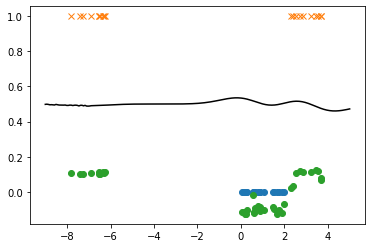

In [78]:
plt.figure()
plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.plot(data.reshape(-1),mu,'o')
plt.plot(x_star.reshape(-1),pi_star,color='k')
# plt.fill_between(x_star.reshape(-1), (logit_predicted_mean-a),(logit_predicted_mean+a),alpha=0.2,color='r')
plt.show()